# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

**NOTE:** This notebook was AI-generated and has not been independently verified. Please exercise caution when interpreting any of the code or results below.

## Overview

[DANDI Dandiset 000617, version 0.250312.0130](https://dandiarchive.org/dandiset/000617/0.250312.0130) is a publicly available dataset from the Allen Institute focused on sequence learning, predictive processing, and two-photon calcium imaging in mouse visual cortex. Mice were shown sequences of natural movie clips across multiple recording sessions using a Cux2-CreERTS2:Camk2a-tTa; Ai93(TITL-GCaMP6f) line, with recordings from key visual cortical regions and both L2/3 and L4 layers.

**Brief description of the study:**  
Adaptive behavior requires neural circuits to predict future events. This project investigates predictive coding hypotheses in the neocortex by examining neural (2-photon calcium) and behavioral (wheel running) data collected before, during, and after sequence learning training using structured and random visual stimuli.

**This notebook will:**
- Demonstrate how to enumerate and query a Dandiset with the DANDI API
- Show how to access and summarize the structure of an NWB file in the dataset
- Load and visualize dF/F (processed calcium activity) for a set of cells
- Visualize the spatial segmentation masks for ROIs (cell detection)
- Illustrate behavioral running speed timeseries
- Highlight how to link out for more interactive exploration (e.g., via Neurosift)
- Provide code templates for further analysis

---

## Required packages

This notebook uses the following Python packages (already installed in this environment):

- dandi
- pynwb
- h5py
- remfile
- matplotlib
- numpy

## Accessing the Dandiset and Listing Assets

Let us connect to the DANDI Archive and get basic metadata for Dandiset 000617.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

dandiset_id = "000617"
dandiset_version = "0.250312.0130"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Description: {metadata['description']}")
print(f"DOI: {metadata['citation'].split()[-1]}")
print(f"URL: {metadata['identifier']} ({metadata['version']})\n")

assets = dandiset.get_assets()
print("First 5 assets in the Dandiset:")
for i, asset in enumerate(islice(assets, 5)):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Allen Institute Openscope - Sequence Learning Project
Description: Adaptive and coordinated behavior requires that an animal be able to make predictions about the near and even far future. This intuition that some neural computations should be ‘predictive’ in their character has a long history, starting with ideas about how the receptive field structure of retinal ganglion cells relate to the statistics of natural visual scenes. Ideas about predictive computation have been most influential in thinking about the function of the neocortex. Here, the relatively stereotyped local circuitry of the neocortex has long led to speculation that each local circuit might be carrying out a somewhat similar, fundamental computation on its specific inputs. In addition, the organization of sensory-motor pathways into hierarchies (e.g., V1, V2, V4, IT in the ventral visual stream) with stereotyped feedforward and feedback connections has motivated ideas about hierarchical predictive code

## Selecting an NWB File for Analysis

For illustration, we focus on the NWB file:

```
sub-677038/sub-677038_ses-1280089433-acq-1280384861_ophys.nwb
```
- DANDI asset ID: `d793b12a-4155-4d22-bd3b-3c49672a5f6a`
- [Direct download URL](https://api.dandiarchive.org/api/assets/d793b12a-4155-4d22-bd3b-3c49672a5f6a/download/)

See this file on [Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/d793b12a-4155-4d22-bd3b-3c49672a5f6a/download/&dandisetId=000617&dandisetVersion=draft) for in-browser visualization and exploration.

## NWB File Structure and Metadata

We will access the NWB file using recommended idioms for cloud-hosted NWB data and summarize its content.

**Note:** Do not display the entire NWB object as output.

In [2]:
import pynwb
import h5py
import remfile

url = "https://api.dandiarchive.org/api/assets/d793b12a-4155-4d22-bd3b-3c49672a5f6a/download/"
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

print(f"Session description: {nwb.session_description}")
print(f"Session start: {nwb.session_start_time}")
print(f"Institution: {getattr(nwb, 'institution', None)}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Genotype: {nwb.subject.genotype}")
print(f"Field of view: {nwb.imaging_planes['imaging_plane_1'].description}")
print(f"Imaging indicator: {nwb.imaging_planes['imaging_plane_1'].indicator}")
print("\nAvailable processing modules:")
for pm_name in nwb.processing:
    print(f"- {pm_name}")
print("\nAvailable acquisition time series:")
for k in nwb.acquisition:
    print(f"- {k}")

Session description: Ophys Session
Session start: 2023-06-30 16:04:51.055000+00:00
Institution: Allen Institute for Brain Science
Subject ID: 677038
Species: Mus musculus
Genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Field of view: (512, 512) field of view in VISam at depth 173 um
Imaging indicator: GCaMP6f

Available processing modules:
- ophys
- running
- stimulus
- stimulus_ophys

Available acquisition time series:
- v_in
- v_sig


### Outline of Key Data in the NWB File

**Processing modules:**  
- `ophys`: Optical physiology (fluorescence, dF/F, segmentation, ROI tables, event detection)
- `running`: Processed running speed and wheel motion
- `stimulus`, `stimulus_ophys`: Stimulus presentation timing and labels

**Acquisition:**  
- Two running wheel voltage time series

**ROI Table:**  
Contains metadata and masks for all segmented cells (ROIs), including spatial location, mask image, cell ID.

**Images:**  
- Average/max projections, segmentation mask image

**Example structure (truncated):**

```
nwb
├── acquisition
│   ├── v_in (TimeSeries)
│   └── v_sig (TimeSeries)
├── processing
│   ├── ophys
│   │   ├── dff (dF/F traces)
│   │   ├── corrected_fluorescence (fluor traces)
│   │   ├── event_detection
│   │   ├── image_segmentation
│   │   └── images (avg/max projection, segmentation mask)
│   ├── running (speed, dx)
│   ├── stimulus, stimulus_ophys (stimulus presentations)
└── subject & imaging metadata
```

## Visualizing Processed Calcium Activity (dF/F) for Example Cells

Next, we plot dF/F traces for 5 example cells over a short segment of the session to illustrate cellular dynamics.

_This example loads a small subset for visualization; the dataset is large, so we do not load all traces at once._

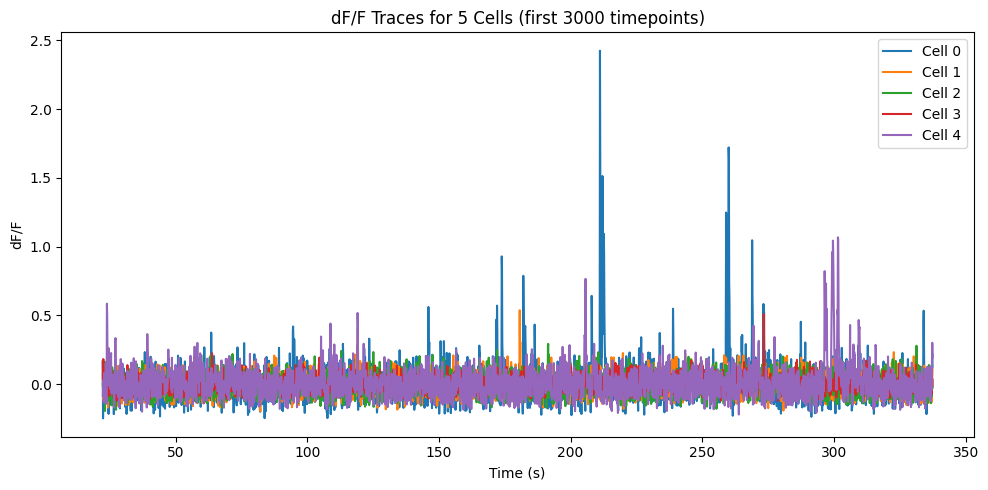

In [3]:
import matplotlib.pyplot as plt
import numpy as np

dfa = nwb.processing["ophys"].data_interfaces["dff"].roi_response_series["traces"]
N_time = 3000
N_cells = 5
dff_data = dfa.data[:N_time, :N_cells]
timestamps = dfa.timestamps[:N_time]

plt.figure(figsize=(10, 5))
for k in range(N_cells):
    plt.plot(timestamps, dff_data[:, k], label=f'Cell {k}')
plt.xlabel("Time (s)")
plt.ylabel("dF/F")
plt.title("dF/F Traces for 5 Cells (first 3000 timepoints)")
plt.legend()
plt.tight_layout()
plt.show()

The example above demonstrates the dynamic range of neural calcium activity, with some cells exhibiting clear transients or events. Users may select different cells, time ranges, or the full set for more in-depth exploration.

## Visualizing Cell Segmentation Masks (ROIs) as an Overlay

Each detected cell is represented by a binary image mask. The overlay below shows the spatial distribution of all segmented cells in the imaging field of view.

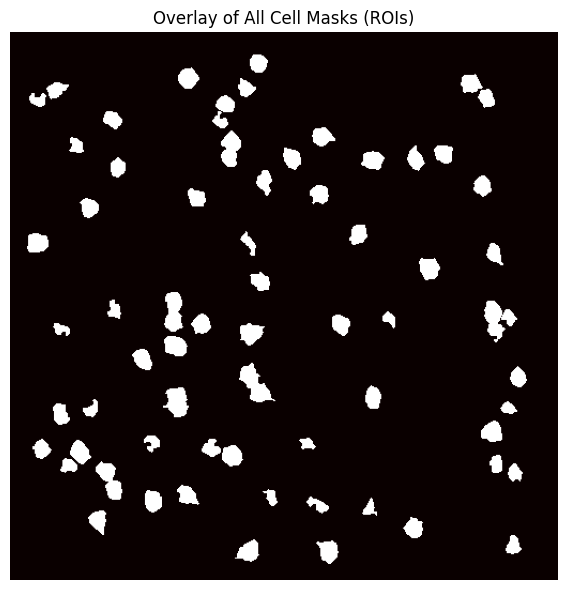

In [4]:
roi_table = nwb.processing["ophys"].data_interfaces["dff"].roi_response_series["traces"].rois.table
masks = np.array([roi_table.image_mask[i] for i in range(len(roi_table.id))])
mask_overlay = np.max(masks, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(mask_overlay, cmap='hot')
plt.title("Overlay of All Cell Masks (ROIs)")
plt.axis('off')
plt.tight_layout()
plt.show()

The overlay illustrates all segmented cell locations in this imaging session. Cells are spatially distributed across the field, with minimal overlap.

## Visualizing Mouse Running Speed (Behavioral Data)

The following plot shows running speed (cm/s) extracted from the processed behavioral time series over 3000 sampled timepoints.

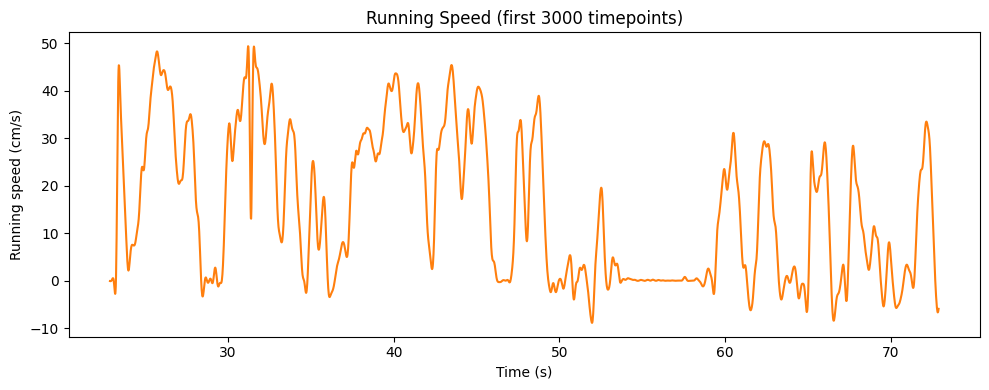

In [5]:
speed_ts = nwb.processing["running"].data_interfaces["speed"]
speed = speed_ts.data[:N_time]
timestamps_speed = speed_ts.timestamps[:N_time]

plt.figure(figsize=(10, 4))
plt.plot(timestamps_speed, speed, color='tab:orange')
plt.xlabel("Time (s)")
plt.ylabel("Running speed (cm/s)")
plt.title("Running Speed (first 3000 timepoints)")
plt.tight_layout()
plt.show()

Clear bouts of running and rest are visible in the behavioral trace above. This illustrates how neural and behavioral data are temporally aligned in this Dandiset and can be jointly analyzed.

For further session/subject/stimulus alignment, see the `stimulus` and `stimulus_ophys` processing modules and intervals.

## Combined Neural–Behavioral Example: dF/F and Running Speed on Common Timeline

Here we plot the dF/F trace from an example cell together with running speed for the same time segment, to illustrate multi-modal alignment.
(For more robust analysis you may want to smooth traces, use more cells, or align to stimulus.)

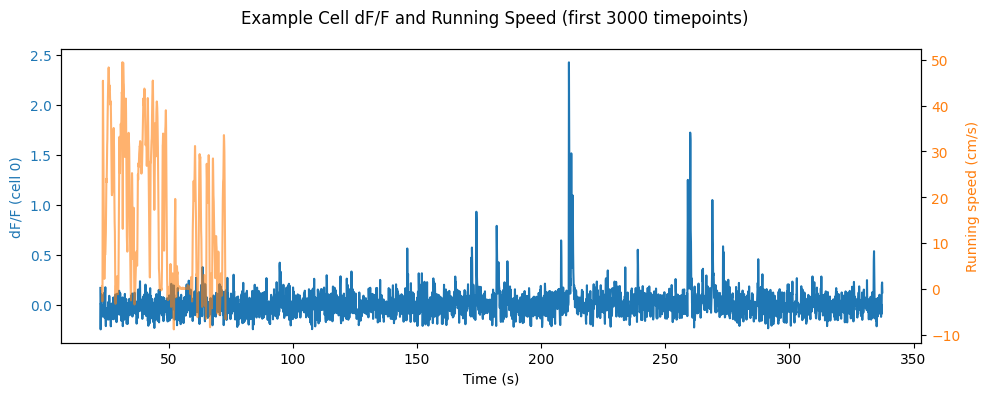

In [6]:
cell_k = 0
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(timestamps, dff_data[:, cell_k], color='tab:blue', label='dF/F cell 0')
ax1.set_ylabel('dF/F (cell 0)', color='tab:blue')
ax1.set_xlabel('Time (s)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(timestamps_speed, speed, color='tab:orange', alpha=0.6, label='Speed')
ax2.set_ylabel('Running speed (cm/s)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
fig.suptitle('Example Cell dF/F and Running Speed (first 3000 timepoints)')
fig.tight_layout()
plt.show()

## Possible Directions for Further Exploration
- Plot ROIs with annotated cell IDs or overlay with mean projection images
- Load more cells, or cluster cells based on activity patterns
- Align neural events to stimulus or running events using interval tables
- Explore structuring and segmentation of imaging data (e.g., mean/max projection images, activity movies)

_To extend this notebook, see the recommended idioms in code above and consult the [Neurosift app](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/d793b12a-4155-4d22-bd3b-3c49672a5f6a/download/&dandisetId=000617&dandisetVersion=draft) for interactive exploration._

---

This concludes the guided exploration of Dandiset 000617. Please proceed with additional analyses as appropriate for your research interests.